## Optimizing over a phase and time shift in match calculations

We define the inner product between two complex waveforms $x(t)$ and $y(t)$ as
$$ \langle x(t) | y(t) \rangle = \mathrm{Re} \left[ \int_{t_i}^{t_f} \mathrm{d}t ~ x(t) ~ y^*(t) \right]. $$

This definition of the inner product doesn't maximise over a phase or time shift, and so neither does the mismatch
$$ \mathcal{M} = 1 - \frac{\langle x(t) | y(t) \rangle}{\sqrt{\langle x(t) | x(t) \rangle ~ \langle y(t) | y(t) \rangle}}.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qnmfits
import utils

from scipy.interpolate import InterpolatedUnivariateSpline as spline

To maximise over a phase shift, consider applying a phase shift $e^{i\varphi}$ to the waveform $y(t)$ in our inner product:

$$ \mathrm{max}_\varphi \left\langle x(t) | y(t)e^{i\varphi} \right\rangle = \mathrm{max}_\varphi \mathrm{Re} \left[ e^{-i\varphi} \int_{t_i}^{t_f} \mathrm{d}t ~ x(t) ~ y^*(t) \right]. $$

This notation means we want to choose $\varphi$ such that we maximise the value of inner product.

Letting $ \int_{t_i}^{t_f} \mathrm{d}t ~ x(t) ~ y^*(t) = z$, where $z$ is a complex number, we want to choose $\varphi$ such that the real part of $e^{-i\varphi}z$ is maximised. This is acheived by rotating $z$ onto the positive real axis. So, $\varphi$ is just the phase of $z$ $\left( z = |z|e^{i\varphi} \right)$ and we have

\begin{align} 
\mathrm{max}_\varphi \left\langle x(t) | y(t)e^{i\varphi} \right\rangle &= \mathrm{Re} \left[ e^{-i\varphi} |z|e^{i\varphi} \right] \\
&= |z| \\
&= \left| \int_{-\infty}^{\infty} \mathrm{d}t ~ x(t) ~ y^*(t) \right|
\end{align}

So, to maximise the inner product over a phase shift we have to take the absolute value (instead of taking the real part).

In [2]:
def phase_maximised_inner_product(times, x, y):
    z = np.trapezoid(x*np.conj(y), x=times)
    return abs(z)

def phase_optimized_mismatch(times, x, y):
    numerator = phase_maximised_inner_product(times, x, y)
    denominator = np.sqrt(phase_maximised_inner_product(times, x, x)*phase_maximised_inner_product(times, y, y))
    return 1 - numerator/denominator

We can optimize over a time shift via brute force (but note that there is a smarter way to do this using the cross-correlation and Parseval's theorem).

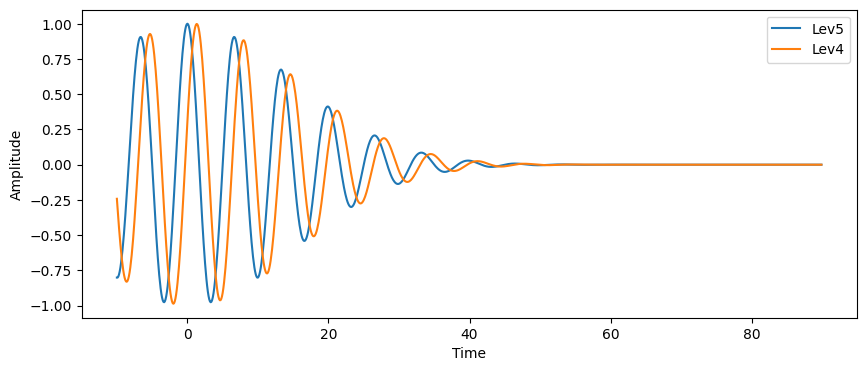

In [3]:
def wavelet(times, t0, f, tau, A, phi):
    return A*np.exp(1j*phi)*np.exp(-1j*2*np.pi*f*(times-t0))*np.exp(-(times-t0)**2/(2*tau**2))

times = np.linspace(-10, 90, 1000, endpoint=False)

wavelet_Lev5 = wavelet(times, t0=0, f=0.15, tau=15, A=1, phi=0)
wavelet_Lev4 = wavelet(times, t0=0.5, f=0.15, tau=15, A=1, phi=np.pi/4)

fig, ax = plt.subplots(figsize=(10,4))

ax.plot(times, wavelet_Lev5.real, label='Lev5')
ax.plot(times, wavelet_Lev4.real, label='Lev4')

ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')

ax.legend();


In [4]:
t0 = 0
T = 80
    
mask = (times > t0) & (times < t0+T)

mm = 1

for roll in [-4,-3,-2,-1,0,1,2,3,4]:
    
    wavelet_Lev4_rolled = np.roll(wavelet_Lev4, roll)
    
    mm_new = phase_optimized_mismatch(times[mask], wavelet_Lev5[mask], wavelet_Lev4_rolled[mask])
    
    if mm_new < mm:
        mm = mm_new
        preferred_roll = roll

print(f'A roll of {preferred_roll} gives a mismatch of {mm:.2e}')

A roll of -4 gives a mismatch of 4.03e-06


### Applying to SXS:BBH_ExtCCE:0005

In [5]:
ID = 5
sim_info = utils.load_cce_data(ID)
sim_Lev5 = sim_info['sim']
chif_Lev5 = sim_Lev5.chif_mag
Mf_Lev5 = sim_Lev5.Mf

In [6]:
sim_info_Lev4 = utils.load_cce_data(ID, lev=4)
sim_Lev4 = sim_info_Lev4['sim']
chif_Lev4 = sim_Lev4.chif_mag
Mf_Lev4 = sim_Lev4.Mf

In [7]:
# Evaluate the Lev4 simulation on the same times as the Lev5 simulation
sim_Lev4_interp_h22 = spline(sim_Lev4.times, np.real(sim_Lev4.h[2,2]), ext=1)(sim_Lev5.times) + \
    1j*spline(sim_Lev4.times, np.imag(sim_Lev4.h[2,2]), ext=1)(sim_Lev5.times)

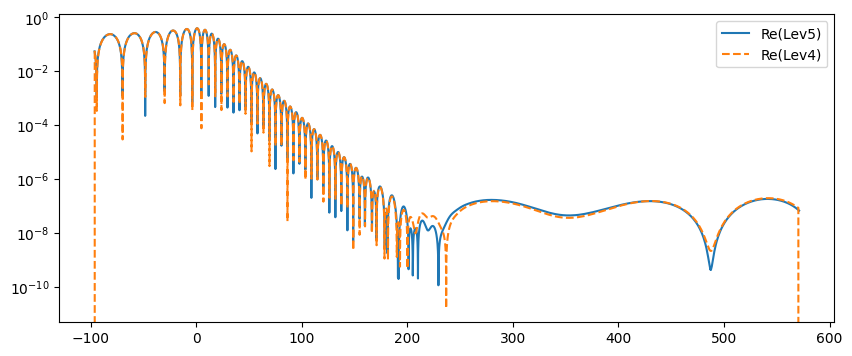

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')

ax.plot(sim_Lev5.times, abs(sim_Lev5.h[2,2].real), c='C0', ls='-', label='Re(Lev5)')
ax.plot(sim_Lev5.times, abs(sim_Lev4_interp_h22.real), c='C1', ls='--', label='Re(Lev4)')

ax.legend();

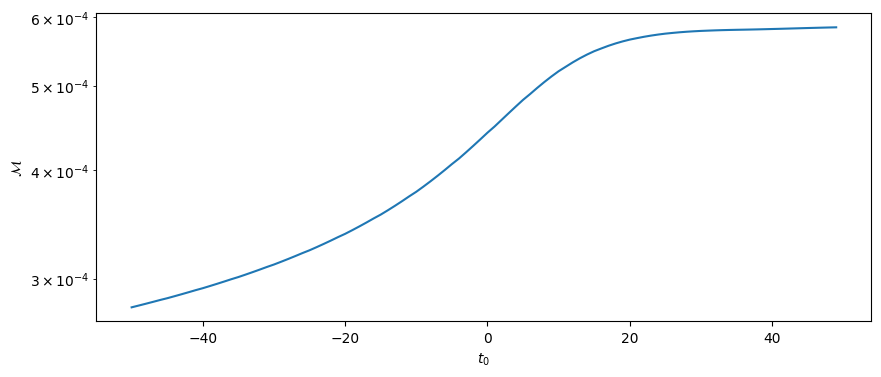

In [9]:
mm_default = []

t0_array = np.linspace(-50, 50, 100, endpoint=False)
T = 100
for t0 in t0_array:
    mask = (sim_Lev5.times > t0) & (sim_Lev5.times < t0+T)
    mm_default.append(qnmfits.mismatch(sim_Lev5.times[mask], sim_Lev5.h[2,2][mask], sim_Lev4_interp_h22[mask]))

fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')

ax.plot(t0_array, mm_default, c='C0', ls='-')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$\mathcal{M}$');

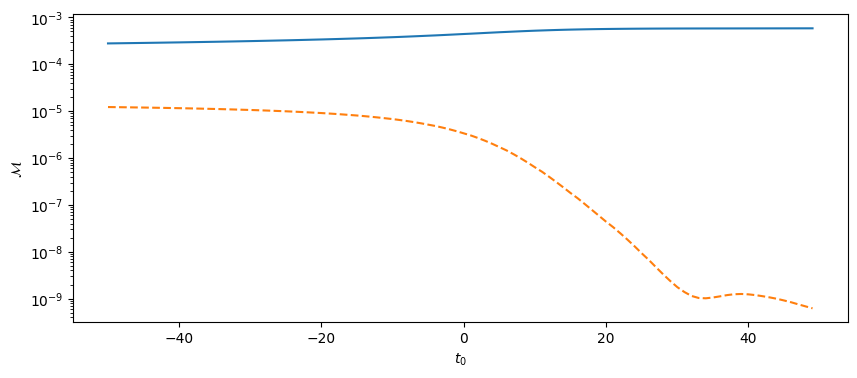

In [10]:
mm_phase = []

t0_array = np.linspace(-50, 50, 100, endpoint=False)
T = 100
for t0 in t0_array:
    mask = (sim_Lev5.times > t0) & (sim_Lev5.times < t0+T)
    mm_phase.append(
        phase_optimized_mismatch(sim_Lev5.times[mask], sim_Lev5.h[2,2][mask], sim_Lev4_interp_h22[mask])
        )

fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')

ax.plot(t0_array, mm_default, c='C0', ls='-')
ax.plot(t0_array, mm_phase, c='C1', ls='--')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$\mathcal{M}$');

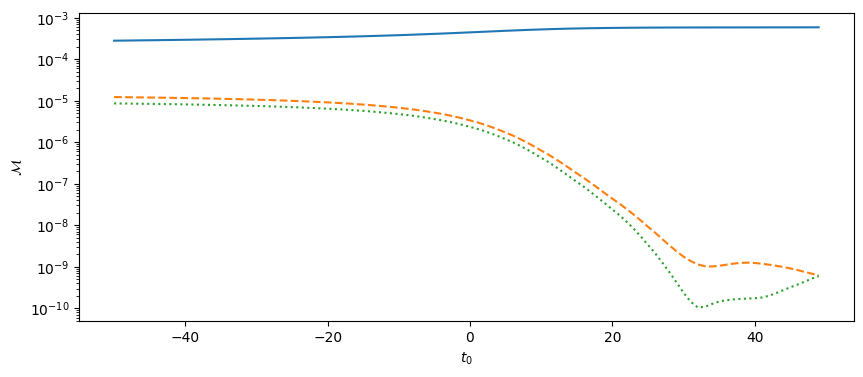

In [11]:
mm_phase_time = []

t0_array = np.linspace(-50, 50, 100, endpoint=False)
T = 100
for t0 in t0_array:
    
    mask = (sim_Lev5.times > t0) & (sim_Lev5.times < t0+T)
    
    mm = 1
    
    for roll in [-4,-3,-2,-1,0,1,2,3,4]:
        
        sim_Lev4_interp_h22_rolled = np.roll(sim_Lev4_interp_h22, roll)
        
        mm_new = phase_optimized_mismatch(sim_Lev5.times[mask], sim_Lev5.h[2,2][mask], sim_Lev4_interp_h22_rolled[mask])
        
        if mm_new < mm:
            mm = mm_new
            preferred_roll = roll

    mm_phase_time.append(mm)

fig, ax = plt.subplots(figsize=(10,4))
ax.set_yscale('log')

ax.plot(t0_array, mm_default, c='C0', ls='-')
ax.plot(t0_array, mm_phase, c='C1', ls='--')
ax.plot(t0_array, mm_phase_time, c='C2', ls=':')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$\mathcal{M}$');